In [2]:
#from tensorflow_docs.vis import embed
from tensorflow import keras
#from imutils import paths

import seaborn as sns
import tensorflow as tf
import pandas as pd
import numpy as np
#import imageio
import cv2
import os
import json
from ipywidgets import Video, Image

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Data preparation

Preparing training data

In [3]:
# data_df = pd. read_csv('/home/app/src/CSV/dataset_df.csv', dtype={"shot": str})

# data_df.drop(columns=['scale_val'], inplace=True)
# data_df.drop(columns = ['move_val'], inplace=True)

# train_path = '/home/app/src/data/shot-type-dataset/trailer_v3/train/'
# data_df['video_name'] = train_path + 'shot_' + data_df['movie'] + '_' + data_df['shot'] + '.mp4'
# train_df = data_df[(data_df['dataset']=='train') | (data_df['dataset']=='val') ]
# train_df = train_df[['video_name', 'move_label','scale_label']]
# train_df = train_df.rename(columns ={'scale_label': 'tag'})


# test_path = '/home/app/src/data/shot-type-dataset/trailer_v3/test/'
# data_df['video_name'] = test_path + 'shot_' + data_df['movie'] + '_' + data_df['shot'] + '.mp4'
# test_df = data_df[data_df['dataset']=='test']
# test_df = test_df[['video_name', 'move_label','scale_label']]
# test_df = test_df.rename(columns ={'scale_label': 'tag'})

In [4]:
#train_df = pd.read_csv('/home/app/src/data/CSV/dataset_train_10k_v1.csv', )

In [5]:
#test_df = pd.read_csv('/home/app/src/data/CSV/dataset_test_10k_v1.csv', )

In [6]:
#train_df.to_csv('/home/app/src/CSV/dataset_train_static.csv')

In [7]:
#test_df.to_csv('/home/app/src/CSV/dataset_test_static.csv')

In [8]:
train_df= pd.read_csv('/home/app/src/CSV/static/dataset_train_static.csv', )
test_df= pd.read_csv('//home/app/src/CSV/static/dataset_test_static.csv', )

In [9]:
train_df= train_df

# train_df = pd.read_csv('/workspaces/final-project-shot-type/data/CSV/dataset_train_v1.csv')
test_df = test_df

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 25466
Total videos for testing: 8187


,Unnamed: 0,video_name,move_label,tag
3584,3584,/home/app/src/data/shot-type-dataset/trailer_v...,Static,LS
18073,18073,/home/app/src/data/shot-type-dataset/trailer_v...,Static,MS
3839,3839,/home/app/src/data/shot-type-dataset/trailer_v...,Static,CS
11604,11604,/home/app/src/data/shot-type-dataset/trailer_v...,Pull,MS
25302,25302,/home/app/src/data/shot-type-dataset/trailer_v...,Static,LS
2106,2106,/home/app/src/data/shot-type-dataset/trailer_v...,Motion,MS
16430,16430,/home/app/src/data/shot-type-dataset/trailer_v...,Static,LS
24870,24870,/home/app/src/data/shot-type-dataset/trailer_v...,Static,MS
15028,15028,/home/app/src/data/shot-type-dataset/trailer_v...,Static,FS
19177,19177,/home/app/src/data/shot-type-dataset/trailer_v...,Motion,LS


In [10]:
train_df['tag'].value_counts()

MS     5656
CS     5578
FS     5161
ECS    4868
LS     4203
Name: tag, dtype: int64

Define hyperparameters

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20

MAX_SEQ_LENGTH = 30
NUM_FEATURES = 2048

Loading frames and working on frame's size

In [12]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

Feature extractor

In [13]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()
print(feature_extractor.summary())

2022-12-08 16:59:10.001162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 16:59:10.010326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 16:59:10.011165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 16:59:10.013048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

87924736/87910968 [==============================] - 2s 0us/step
Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________

Working on labels

In [14]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CS', 'ECS', 'FS', 'LS', 'MS']


Preparing videos

In [15]:
# def prepare_all_videos(df, root_dir):
#     num_samples = len(df)
#     video_paths = df["video_name"].values.tolist()
#     labels = df["tag"].values
#     labels = label_processor(labels[..., None]).numpy()

#     # `frame_masks` and `frame_features` are what we will feed to our sequence model.
#     # `frame_masks` will contain a bunch of booleans denoting if a timestep is
#     # masked with padding or not.
#     frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
#     frame_features = np.zeros(
#         shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
#     )

#     # For each video.
#     for idx, path in enumerate(video_paths):
#         # Gather all its frames and add a batch dimension.
#         frames = load_video(os.path.join(root_dir, path))
#         frames = frames[None, ...]

#         # Initialize placeholders to store the masks and features of the current video.
#         temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
#         temp_frame_features = np.zeros(
#             shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
#         )

#         # Extract features from the frames of the current video.
#         for i, batch in enumerate(frames):
#             video_length = batch.shape[0]
#             length = min(MAX_SEQ_LENGTH, video_length)
#             for j in range(length):
#                 temp_frame_features[i, j, :] = feature_extractor.predict(
#                     batch[None, j, :]
#                 )
#             temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

#         frame_features[idx,] = temp_frame_features.squeeze()
#         frame_masks[idx,] = temp_frame_mask.squeeze()

#     return (frame_features, frame_masks), labels


# train_data, train_labels = prepare_all_videos(train_df, "train")
# test_data, test_labels = prepare_all_videos(test_df, "test")

# print(f"Frame features in train set: {train_data[0].shape}")
# print(f"Frame masks in train set: {train_data[1].shape}")

Saving embeddings

Train

In [16]:
#train_data_embedding_0_10k = np.save('/workspaces/final-project-shot-type/embeddings/train_data_embedding_0_10k.npy', train_data[0])

In [17]:
#train_data_embedding_1_10k = np.save('/workspaces/final-project-shot-type/embeddings/train_data_embedding_1_10k.npy', train_data[1])

In [18]:
#train_labels_embedding_10k = np.save('/workspaces/final-project-shot-type/embeddings/train_labels_embedding_10k.npy', train_labels)

Test

In [19]:
#test_data_embedding_0_10k = np.save('/workspaces/final-project-shot-type/embeddings/test_data_embedding_0_10k.npy', test_data[0])

In [20]:
#test_data_embedding_1_10k = np.save('/workspaces/final-project-shot-type/embeddings/test_data_embedding_1_10k.npy', test_data[1])

In [21]:
#test_labels_embedding_10k = np.save('/workspaces/final-project-shot-type/embeddings/test_labels_embedding_10k.npy', test_labels)

Loading embeddings

In [22]:
path_load_embeddings= '/home/app/src/embeddings/'

#Train
train_data_0 = np.load(path_load_embeddings + 'train_data_embedding_0_full_30F.npy')
train_data_1 = np.load(path_load_embeddings + 'train_data_embedding_1_full_30F.npy')
train_data=(train_data_0, train_data_1)
train_labels = np.load(path_load_embeddings + 'train_labels1_embedding_full_30F.npy')

#Test
test_data_0 = np.load(path_load_embeddings + 'test_data_embedding_0_full_30F.npy')
test_data_1 = np.load(path_load_embeddings + 'test_data_embedding_1_full_30F.npy')
test_data=(test_data_0, test_data_1)
test_labels = np.load(path_load_embeddings + 'test_labels1_embedding_full_30F.npy')

Sequence model (RNN)

In [23]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"],
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5"
    filepath_log = '/home/app/src/experiments/inceptionv3_GRU/static'
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )
    tensor_board = keras.callbacks.TensorBoard (filepath_log)

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint, reduce_lr, tensor_board],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # Getting predictions
    y_pred_proba = seq_model.predict([test_data[0], test_data[1]])
    y_pred = []   
    for arr in y_pred_proba:
        idx_max = np.argmax(arr)
        y_pred.append(idx_max)

    return history, seq_model, y_pred


_, sequence_model, y_pred = run_experiment()

2022-12-08 17:00:47.528413: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4380917760 exceeds 10% of free system memory.
2022-12-08 17:00:51.700073: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4380917760 exceeds 10% of free system memory.


Epoch 1/20


2022-12-08 17:01:02.912760: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


557/558 [============================>.] - ETA: 0s - loss: 1.0486 - accuracy: 0.6015

2022-12-08 17:01:16.598514: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1877606400 exceeds 10% of free system memory.
2022-12-08 17:01:18.497543: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1877606400 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.61452, saving model to /home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5
558/558 [==============================] - 30s 37ms/step - loss: 1.0485 - accuracy: 0.6015 - val_loss: 0.6145 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 2/20
557/558 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.7530
Epoch 2: val_loss did not improve from 0.61452
558/558 [==============================] - 14s 25ms/step - loss: 0.6886 - accuracy: 0.7529 - val_loss: 0.6188 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 3/20
556/558 [============================>.] - ETA: 0s - loss: 0.6171 - accuracy: 0.7846
Epoch 3: val_loss improved from 0.61452 to 0.56197, saving model to /home/app/src/experiments/inceptionv3_GRU/static/model.weights_static.h5
558/558 [==============================] - 15s 26ms/step - loss: 0.6177 - accuracy: 0.7845 - val_loss: 0.5620 - val_accuracy: 0.7959 - lr: 0.0010
Epoch 4/20
557/558 [========================

2022-12-08 17:06:02.233059: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2012037120 exceeds 10% of free system memory.


256/256 [==============================] - 3s 11ms/step - loss: 0.4690 - accuracy: 0.8364
Test accuracy: 83.64%


In [24]:
%tensorboard == logdir /home/app/src/final-project-shot-type/experiments/inceptionv3_GRU/static

UsageError: Line magic function `%tensorboard` not found.


<AxesSubplot: >

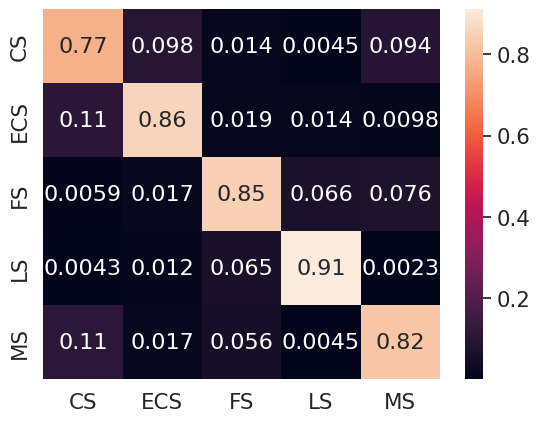

In [25]:
# Confussion Matrix
c_matrix = confusion_matrix(test_labels, y_pred , normalize='pred')
# Plotting
class_vocab = label_processor.get_vocabulary()
df_cm = pd.DataFrame(c_matrix,index = [i for i in class_vocab],
                  columns = [i for i in class_vocab])
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

In [26]:
# Metrics report
class_vocab = label_processor.get_vocabulary()
print(classification_report(test_labels, y_pred, target_names=class_vocab ))

              precision    recall  f1-score   support

          CS       0.77      0.81      0.79      1792
         ECS       0.86      0.84      0.85      1641
          FS       0.85      0.84      0.84      1642
          LS       0.91      0.90      0.90      1359
          MS       0.82      0.81      0.82      1753

    accuracy                           0.84      8187
   macro avg       0.84      0.84      0.84      8187
weighted avg       0.84      0.84      0.84      8187



Predictions

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
real_label = test_df[test_df['video_name'] ==test_video]['tag'].iloc[0]
print(f'Real Label: {real_label}')
new_ = Video.from_file(test_video,play=True)
new_
#to_gif(test_frames[:MAX_SEQ_LENGTH])